<a href="https://colab.research.google.com/github/vuviethung1998/rl-graph-entity-alignment/blob/main/src/notebooks/RLEA_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [ ]:
import gym
from scipy import spatial
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from collections import namedtuple, deque
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm

In [100]:
def build_adj_matrix_and_embeddings():

  # Build adj matrix
  file1 = open('/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/data/rel_triples_id_1.txt', 'r')
  lines1 = file1.readlines()
  lines1 = lines1[:1000]
  g1 = []
  for line in lines1:
    g1.append([int(x) for x in line.strip().split("\t")])
  g1 = np.array(g1)

  file2 = open('/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/data/rel_triples_id_2.txt', 'r')
  lines2 = file2.readlines()
  lines2 = lines2[:1000]
  g2 = []
  for line in lines2:
    g2.append([int(x) for x in line.strip().split("\t")])
  g2 = np.array(g2)
  mapping_index_1 = {}
  mapping_index_2 = {}
  unique1 = np.unique(g1)
  unique2 = np.unique(g2)
  for i in range(len(unique1)):
    mapping_index_1[unique1[i]] = i

  for i in range(len(unique2)):
    mapping_index_2[unique2[i]] = i

  G1_nodes = len(np.unique(g1))
  G2_nodes = len(np.unique(g2))
  # print("num nodes: ", G1_nodes)
  # print("num nodes: ", G2_nodes)
  G1_adj_matrix = np.empty(shape=(G1_nodes, G1_nodes))
  G2_adj_matrix = np.empty(shape=(G2_nodes, G2_nodes))
  # print(mapping_index_1)
  # print(mapping_index_2)
  for i in range(len(g1)):
    head = g1[i][0]
    tail = g1[i][2]
    G1_adj_matrix[mapping_index_1[head]][mapping_index_1[tail]] = 1
    G1_adj_matrix[mapping_index_1[tail]][mapping_index_1[head]] = 1
  for i in range(len(g1)):
    head = g2[i][0]
    tail = g2[i][2]
    G2_adj_matrix[mapping_index_2[head]][mapping_index_2[tail]] = 1
    G2_adj_matrix[mapping_index_2[tail]][mapping_index_2[head]] = 1
  # print(np.count_nonzero(G1_adj_matrix == 1))
  # print(np.count_nonzero(G2_adj_matrix == 1))

  # Build embeddings
  emb1 = []
  emb2 = []
  # transitivity = np.load("/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/data/transitivity_emb.npy")
  proximi = np.load("/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/data/proximi_emb.npy")
  for i, _ in enumerate(mapping_index_1):
    emb1.append(proximi[i])
  for i, _ in enumerate(mapping_index_2):
    emb2.append(proximi[i])
  emb1 = np.array(emb1)
  emb2 = np.array(emb2)


  # Get ground truth
  ground_truth = {}
  file_gt = open('/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/data/ground_truth.txt', 'r')
  lines = file_gt.readlines()
  gt = []
  for line in lines:
    gt.append([int(x) for x in line.strip().split("\t")])
  gt = np.array(gt)
  
  for i in range(len(gt)):
    index_x = gt[i][0]
    index_y = gt[i][1]
    if index_x in mapping_index_1 and index_y in mapping_index_2:
      ground_truth[mapping_index_1[index_x]] = mapping_index_2[index_y] 

  return G1_adj_matrix, G2_adj_matrix, emb1, emb2, ground_truth

In [ ]:
G1_adj_matrix, G2_adj_matrix, emb1, emb2, ground_truth = build_adj_matrix_and_embeddings()

In [ ]:
from scipy import spatial

def get_cosine_similarity(vector_1, vector_2):
  return spatial.distance.cosine(vector_1, vector_2)

def get_k_nearest_items(lst_group_vector_1, lst_group_vector_2, k):
  '''
    Get 5 vector closest to vector_1
    E.g: vector_1 = 3
    Return 12345 in lst_group_vector_2 => lay d xong sort 
  '''
  vector = lst_group_vector_1[0]['vector']
  sorted_vector_2 = sorted(lst_group_vector_2, key=(lambda t: get_cosine_similarity(t['vector'], vector)) )
  res = sorted_vector_2[0:k]
  return res

# Memory

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward'))
class Memory(object):
    def __init__(self):
        self.memory = deque()

    def push(self, state, action, reward):
        self.memory.append(Transition(state, action, reward))

    def sample(self):
        memory = self.memory
        return Transition(*zip(*memory)) 

    def __len__(self):
        return len(self.memory)

# Agent

In [ ]:
class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer = nn.Linear(state_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = nn.Sigmoid(self.dense_layer(x))
        return self.output(x)

In [ ]:
from torch.nn.parameter import Parameter

class GCN_layer(nn.Module):
    """
      Define filter layer 1/2 like in the above image
      Calculate A_hat first then,
      Input: adj_matrix with input features X
    """   

    def __init__(self, first_adj_matrix, second_adj_matrix, inputs_shape, outputs_shape):
        super(GCN_layer, self).__init__()

        self.W=Parameter(torch.rand(inputs_shape,outputs_shape),requires_grad=True)
        self.bias = Parameter(torch.rand(outputs_shape),requires_grad=True)
        A=torch.from_numpy(first_adj_matrix).type(torch.LongTensor).to(device)
        I=torch.eye(A.shape[0]).to(device)
        A_hat=A+I
        D=torch.sum(A_hat,axis=0)
        D=torch.diag(D)
        D_inv=torch.inverse(D)
        self.A_hat_x = torch.mm(torch.mm(D_inv,A_hat),D_inv)
        
        A=torch.from_numpy(second_adj_matrix).type(torch.LongTensor).to(device).to(device)
        I=torch.eye(A.shape[0]).to(device)
        A_hat=A+I
        D=torch.sum(A_hat,axis=0)
        D=torch.diag(D)
        D_inv=torch.inverse(D)
        self.A_hat_y = torch.mm(torch.mm(D_inv,A_hat),D_inv)
    
    def forward(self, i, input_features):
        if i == "x":
          aggregate=torch.mm(self.A_hat_x, input_features)
        else: 
          aggregate=torch.mm(self.A_hat_y, input_features)    
        propagate=torch.mm(aggregate, self.W)+self.bias             
        return propagate

In [101]:
class Agent(nn.Module):
    def __init__(self, first_adj_matrix, second_adj_matrix, inputs_shape,outputs_shape,n_classes,activation='Sigmoid'):
        super(Agent, self).__init__()

        self.layer1=GCN_layer(first_adj_matrix, second_adj_matrix, inputs_shape, outputs_shape)
        self.layer2=GCN_layer(first_adj_matrix, second_adj_matrix, outputs_shape, n_classes)
        self.n_classes = n_classes
        
        if activation =='Tanh':
            self.activation = nn.Tanh()
        elif activation=='Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation=='Softmax':
            self.activation=nn.Softmax()
        elif activation=='Relu':
            self.activation=nn.ReLU()
    
        self.softmax=nn.Softmax(dim=1)
        self.sigmoid=nn.Sigmoid()
        self.W_h=Parameter(torch.rand(1, 2), requires_grad=True)
        self.W_f=Parameter(torch.rand(n_classes, n_classes), requires_grad=True)
        self.W_p=Parameter(torch.rand(1, 1), requires_grad=True)
        self.bias_h = Parameter(torch.rand(1),requires_grad=True)
    
    # Gett k nearest opponents for mutual information estimator
    def get_k_nearest_opponent(self, G, node, k=3):
        G_list = [(i, item) for i, item in enumerate(G)]
        # Tìm nearest thế này là gồm cả chính node đó
        nearest_node = sorted(G_list, key=(lambda other_node: F.cosine_similarity(torch.reshape(other_node[1], (1, -1)), node)), reverse=True)
        k_nearest_opponent = nearest_node[:k]
        k_nearest_opponent_vector = [G[item[0]] for item in k_nearest_opponent]
        return k_nearest_opponent_vector

    def forward(self, first_embeddings, second_embeddings, state):
        index_x = state[0]
        index_y = state[1]
        x=self.layer1("x", first_embeddings)
        x=self.activation(x)
        x=self.layer2("x", x)
        G_x = self.activation(x)

        y=self.layer1("y", second_embeddings)
        y=self.activation(y) 
        y=self.layer2("y", y)
        G_y = self.activation(y)
        g_x = torch.reshape(G_x[index_x], (1, self.n_classes))
        g_y = torch.reshape(G_y[index_y], (1, self.n_classes))

        # Linear combination
        cat_gxgy = torch.cat((g_x, g_y), 0)
        h = self.sigmoid(torch.mm(self.W_h, cat_gxgy) + self.bias_h)

        # Mutual information estimator
        f = torch.exp(g_x.T*self.W_f*g_y)
        k_nearest_opponent_vector = self.get_k_nearest_opponent(G_y, g_y, k=11) # Bao gồm cả chính node e_y nên lấy k=11. Paper nói là k=10
        list_temp = [torch.exp(g_x.T*self.W_f*oppo) for oppo in k_nearest_opponent_vector]
        f_oppo = torch.stack(list_temp).sum()
        I = f/f_oppo

        # Policy
        policy = self.softmax(torch.mm(self.W_p, torch.cat((h, I), 1)))
        return policy

    # Train model using reinforcement learning
    @classmethod
    def train_model(self, first_embeddings, second_embeddings, net, transitions, optimizer):
        states, actions, rewards = transitions.state, transitions.action, transitions.reward

        actions = torch.stack(actions).to(device)
        rewards = torch.Tensor(rewards).to(device)
        returns = torch.zeros_like(rewards).to(device)
        vf = torch.zeros_like(rewards).to(device)
        total_loss = 0
        running_return = 0
        for t in reversed(range(len(rewards))):
            # calculate G from the last transition
            running_return = gamma**0 * rewards[t] + gamma * running_return
            returns[t] = running_return
            if returns.sum() == 0:
              vf[t] = 0.01
            else:
              vf[t] = running_return/returns.sum()
            # get value function estimates
            advantage = returns[t] - vf[t]

            # loss
            policies = net(first_embeddings, second_embeddings, states[t])
            # sum all features/embedding vectors of the state
            log_policies = (torch.log(policies) * actions[t].detach()).sum(dim=1)
            loss = (-log_policies * advantage).sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss
        
        return total_loss

    def get_action(self, first_embeddings, second_embeddings, state):
        policy = self.forward(first_embeddings, second_embeddings, state)
        p = policy[0].cpu().data.numpy()
        action = np.random.choice(2, 1, p=p)[0]
        return action

# Environment

In [102]:
G1_adj_matrix, G2_adj_matrix, emb1, emb2, ground_truth = build_adj_matrix_and_embeddings()
from scipy import spatial
def get_k_nearest_candidate(target_node, k=11):
  nearest_list = [(i, emb2[i]) for i in range(len(emb2))]
  list_similarity = sorted(nearest_list, key=(lambda nearest_node: 1 - spatial.distance.cosine(nearest_node[1], emb2[target_node])), reverse=True)
  list_similarity = list_similarity[:k]
  k_nearest_nodes = [item[0] for item in list_similarity]
  return k_nearest_nodes

def getHashTable2():
  hash_mapping_node = {}
  for source_node, target_node in ground_truth.items():
    hash_mapping_node[source_node] = get_k_nearest_candidate(target_node)
  return hash_mapping_node

In [110]:
# đổi lại thành dạng hash table 
import gym
import numpy as np
from gym import spaces
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

G1_adj_matrix, G2_adj_matrix, emb1, emb2, ground_truth = build_adj_matrix_and_embeddings()

def get_k_nearest_candidate(target_node, emb2, k=11):
  nearest_list = [(i, emb2[i]) for i in range(len(emb2))]
  list_similarity = sorted(nearest_list, key=(lambda nearest_node: 1 - spatial.distance.cosine(nearest_node[1], emb2[target_node])), reverse=True)
  list_similarity = list_similarity[:k]
  k_nearest_nodes = [item[0] for item in list_similarity]
  return k_nearest_nodes

def getHashTable(ground_truth, emb2):
  '''
    Input: groundtruth, 
  '''
  hash_mapping_node = {}
  for source_node, target_node in ground_truth.items():
    hash_mapping_node[source_node] = get_k_nearest_candidate(target_node, emb2)
  return hash_mapping_node

def getAlignTable():
  return ground_truth

def getListState(hash_table):
  lst_state = []
  for key in hash_table.keys():
    lst_key_2 = hash_table[key]
    for key_2 in lst_key_2:
      lst_state.append((int(key), key_2))
  return lst_state

def getNodeEmbeddingByKey(emb, id):
  return emb[id]

def popCurrentState(lst_state, current_state):
  # print('currstate: ', current_state)
  key1, key2 = current_state[0], current_state[1]
  # print((key1, key2))

  lst_remove = []
  for state in lst_state:
    key_state_1 = state[0]
    key_state_2 = state[1]
    # print('cur_state: ', state)

    if key_state_1==key1 or key_state_2 == key1 or key_state_1==key2 or key_state_2==key2:
      lst_remove.append(state)
  lst_final = list(set(lst_state) - set(lst_remove))
  return lst_final
    
def isAligned(state):
  alignTable = getAlignTable()
  true_state = (state[0], alignTable[state[0]])
  if state==true_state:
    return True
  return False

class SequentialMatchingEnv(gym.Env): 
  """
  Custom Environment for Binary Scheme
  """
  # Because of google colab, we cannot implement the GUI ('human' render mode)
  metadata = {'render.modes': ['console']}
  # Define constants for action
  MATCH = 1
  UNMATCH = 0  
  
  MIN_SKIP_RATE = 0.01
  BASIC_SKIP_RATE = 0.8
  DISCOUNT_RATIO = 0.9
  THETA = 1

  def __init__(self, k_nearest=5 ):
    super(SequentialMatchingEnv, self).__init__()

    self.seed = random.randint(0,100)

    # init no vectors
    # self.vector_size = vector_size
    # self.k_nearest = k_nearest
    
    self.hash_table = getHashTable(ground_truth, emb2)
    self.list_state = getListState(self.hash_table)
    # init total reward   
    self.total_reward = 0 

    # define action and observation space 
    n_actions = 2
    self.action_space = spaces.Discrete(n_actions)

    # observation will be the source vector and the target vector with each (1,5)vector 
    self.observation_space =  spaces.Box(low=0, high=1, shape=(2,5), dtype=np.float16)
    
  def reset(self):
    """
      Important: The observation must be numpy array 
      : return: (np.array)
    """
    self.lst_state = getListState(self.hash_table) # get all state possible 

    first_state = self.lst_state[0]
    self.state_embedding = np.array([getNodeEmbeddingByKey(emb1, first_state[0]), 
                               getNodeEmbeddingByKey(emb2, first_state[1])])
    return self.lst_state[0]

  def step(self, action, episode_num=1):

    self.episode_num = episode_num
    current_state = self.lst_state[0]

    # cur_cosine_sim = get_cosine_similarity(getNodeEmbeddingByKey(1, current_state[0]), getNodeEmbeddingByKey(2, current_state[1]))
    if action == self.MATCH:
      # if match pop all state containing two key of current state 
      self.lst_state = popCurrentState(self.lst_state, current_state)

      # check value if true match
      if isAligned(current_state): # label = 1 => difficulty = Cemax,ex - Cexey
        # difficulty = max_cosine_sim - cur_cosine_sim 
        # skip_rate = max(self.MIN_SKIP_RATE, (self.DISCOUNT_RATIO ** (self.episode_num - 1)) * self.BASIC_SKIP_RATE * difficulty)

        # random_p = random.random()
        # if random_p < skip_rate:
        #   score = 0
        # else:
        score = 1

      elif not isAligned(current_state): # label = 0 => difficulty = theta - (Cemax,ex - Cexey)
        # difficulty = self.THETA - (max_cosine_sim - cur_cosine_sim)
        # skip_rate = max(self.MIN_SKIP_RATE, (self.DISCOUNT_RATIO ** (self.episode_num - 1)) * self.BASIC_SKIP_RATE * difficulty)
        # random_p = random.random()
        # if random_p > skip_rate: # neu k skip
        score = 0
        # else: score = 0 # neu skip, score = 0 va 
    elif action == self.UNMATCH:
      # if mismatch pop head of group vector 2 
      self.lst_state.pop(0)

      # if true mismatch -> LABEL = 0 => difficulty = theta - (Cemax,ex - Cexey)
      if not isAligned(current_state): 
        # difficulty = self.THETA - (max_cosine_sim - cur_cosine_sim)
        # skip_rate = max(self.MIN_SKIP_RATE, (self.DISCOUNT_RATIO ** (self.episode_num - 1)) * self.BASIC_SKIP_RATE * difficulty)
        # skip hay khong deu khong anh huong
        score = 0 
      # if false mismatch 
      elif isAligned(current_state): 
        # difficulty = max_cosine_sim - cur_cosine_sim
        # skip_rate = max(self.MIN_SKIP_RATE, (self.DISCOUNT_RATIO ** (self.episode_num - 1)) * self.BASIC_SKIP_RATE * difficulty)

        # random_p = random.random()
        # if random_p < skip_rate:
        #   score = 0
        # else:
        score = -10
    else:
      raise ValueError("Received invalid action={} which is not part of the action space".format(action))
    info = {}

    if len(self.lst_state) == 0:
      next_embedding = None
      next_state = (None, None) # khong con phan tu nao trong G1
      done = True
    else:
      # get next state id and next state embedding 
      next_state = self.lst_state[0]
      next_embedding = np.array([getNodeEmbeddingByKey(emb1, next_state[0]), 
                               getNodeEmbeddingByKey(emb2, next_state[1])])
      done = False
    return current_state, next_state, next_embedding, score, done, info

In [111]:
hash_mapping_node = getHashTable(ground_truth, emb2)
print(hash_mapping_node)

{196: [188, 93, 742, 711, 718, 337, 138, 227, 288, 77, 70], 1359: [1461, 999, 7, 128, 34, 280, 407, 390, 1648, 1107, 1650], 191: [154, 367, 1619, 1018, 1321, 1264, 989, 1291, 1543, 450, 1292], 689: [647, 810, 749, 748, 463, 538, 911, 556, 431, 670, 491], 402: [419, 454, 703, 658, 228, 247, 421, 1329, 341, 1115, 1302], 144: [189, 170, 436, 447, 865, 543, 113, 958, 24, 660, 987], 96: [71, 94, 1574, 1343, 212, 459, 752, 555, 165, 554, 1449], 47: [38, 109, 130, 257, 210, 233, 84, 688, 472, 357, 522], 1597: [1162, 1087, 1488, 1355, 1658, 1145, 541, 490, 123, 267, 355], 114: [105, 168, 253, 296, 598, 47, 580, 405, 879, 992, 1217], 52: [68, 92, 282, 207, 738, 662, 215, 101, 387, 230, 1225], 382: [330, 275, 574, 206, 1038, 57, 384, 453, 923, 58, 155], 159: [136, 139, 1163, 498, 245, 626, 621, 125, 278, 144, 135], 668: [1098, 1603, 720, 1467, 466, 1476, 1472, 962, 140, 995, 590], 82: [59, 62, 1267, 1224, 1353, 347, 1410, 182, 223, 603, 624], 334: [319, 272, 1227, 1522, 891, 1524, 252, 712, 778,

In [112]:
print(ground_truth)

{196: 188, 1359: 1461, 191: 154, 689: 647, 402: 419, 144: 189, 96: 71, 47: 38, 1597: 1162, 114: 105, 52: 68, 382: 330, 159: 136, 668: 1098, 82: 59, 334: 319, 43: 39, 19: 51, 321: 210, 1: 16, 502: 535, 182: 165, 78: 92, 827: 1031, 76: 61, 95: 85, 507: 374, 343: 265, 21: 14, 662: 742, 197: 215, 24: 35, 392: 346, 856: 529, 275: 259, 975: 561, 461: 452, 213: 223, 673: 752, 508: 579, 712: 987, 1045: 915, 85: 94, 266: 220, 887: 1187, 33: 22, 80: 46, 112: 104, 13: 40, 608: 539, 826: 842, 137: 128, 961: 1030, 733: 797, 482: 477, 459: 365, 40: 36, 57: 24, 573: 606, 434: 388, 124: 125, 784: 807, 400: 449, 549: 431, 646: 616, 375: 363, 142: 209, 552: 499, 740: 936, 394: 470, 59: 69, 663: 809, 425: 341, 249: 262, 308: 327, 81: 88, 113: 86, 419: 511, 22: 21, 749: 951, 1410: 1357, 143: 122, 1394: 1377, 309: 312, 421: 393, 44: 45, 26: 13, 29: 28, 1177: 1105, 974: 786, 153: 79, 753: 880, 851: 562, 357: 299, 15: 2, 408: 585, 1241: 857, 1219: 1339, 1018: 745, 287: 183, 541: 324, 585: 646, 108: 180, 110:

# Train

In [113]:
G1_adj_matrix, G2_adj_matrix, emb1, emb2, ground_truth = build_adj_matrix_and_embeddings()

In [114]:
# first_adj_matrix, second_adj_matrix = build_adj_maxtrix()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
first_embeddings_torch=torch.from_numpy(emb1).type(torch.FloatTensor).to(device)
second_embeddings_torch=torch.from_numpy(emb2).type(torch.FloatTensor).to(device)

In [115]:
lr = 0.0001
torch.manual_seed(500)
net = Agent(G1_adj_matrix, G2_adj_matrix, emb1.shape[1], 16, 1, activation='Sigmoid')
optimizer = optim.Adam(net.parameters(), lr=lr)
net.to(device)
net.train()

Agent(
  (layer1): GCN_layer()
  (layer2): GCN_layer()
  (activation): Sigmoid()
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
)

In [116]:
env = SequentialMatchingEnv()
gamma = 0.99
rewards_lst = [] 
episodes = 1
lst_state = []
results = []

for ep in tqdm(range(1, episodes + 1)):
  idx = env.reset()
  memory = Memory()
  reward_episode = 0
  done = False
  # define policy and action
  while True:
    # get environment state
    # print('first_embeddings_torch - second_embeddings_torch: {} \n {}'.format(first_embeddings_torch, second_embeddings_torch))
    action = net.get_action(first_embeddings_torch, second_embeddings_torch, idx)
    cur_idx, next_idx, obs, reward, done, info = env.step(action, ep)
    if done:
      break
    # add reward 
    reward_episode += reward

    # push to memory for training model
    action_one_hot = torch.zeros(2)
    action_one_hot[action] = 1
    memory.push(next_idx, action_one_hot, reward)

    # next state
    idx = next_idx
    lst_state.append((cur_idx, action, reward))
    
  loss = net.train_model(first_embeddings_torch, second_embeddings_torch, net, memory.sample(), optimizer)
  results.append([ep, reward_episode, loss.cpu().detach().numpy()])
  if reward_episode > 15:
    print("Goal reached!", "reward=", reward)
    break

results = np.array(results)

100%|██████████| 1/1 [06:25<00:00, 385.21s/it]


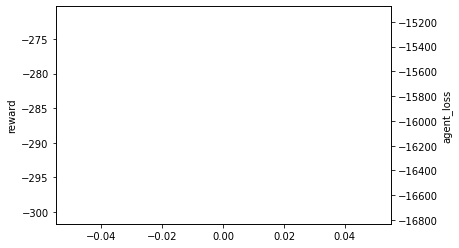

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
results = pd.DataFrame(results, columns=['episode', 'reward', 'agent_loss'])
sns.lineplot(data=results.reward, color="g")
ax2 = plt.twinx()
sns.lineplot(data=results.agent_loss, color="b", ax=ax2)
plt.show()

In [118]:
print(lst_state)

[((196, 188), 0, -10), ((196, 93), 0, 0), ((196, 742), 0, 0), ((196, 711), 0, 0), ((196, 718), 0, 0), ((196, 337), 1, 0), ((161, 662), 1, 0), ((179, 892), 0, 0), ((645, 615), 0, -10), ((1677, 1392), 0, 0), ((321, 357), 1, 0), ((1479, 927), 1, 0), ((820, 1064), 0, 0), ((753, 346), 1, 0), ((19, 417), 1, 0), ((243, 584), 0, 0), ((334, 252), 1, 0), ((497, 1266), 1, 0), ((95, 1515), 1, 0), ((609, 209), 1, 0), ((462, 1486), 1, 0), ((15, 1454), 0, 0), ((1394, 619), 0, 0), ((748, 1302), 0, 0), ((421, 228), 1, 0), ((904, 1080), 0, 0), ((1018, 1466), 0, 0), ((269, 304), 0, 0), ((608, 459), 1, 0), ((1523, 1625), 0, 0), ((143, 806), 0, 0), ((701, 1411), 0, 0), ((650, 663), 1, 0), ((541, 324), 0, -10), ((72, 67), 0, 0), ((419, 502), 1, 0), ((22, 12), 0, 0), ((756, 1247), 0, 0), ((1434, 1558), 0, 0), ((887, 375), 1, 0), ((1610, 1042), 1, 0), ((374, 531), 0, 0), ((1462, 1448), 1, 1), ((476, 506), 0, 0), ((825, 1045), 0, 0), ((645, 770), 1, 0), ((261, 861), 0, 0), ((120, 9), 0, 0), ((262, 580), 1, 0),